In [ ]:
!pip install -U -q pydrive

In [ ]:
!pip install gTTS

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [ ]:
cd My\ Drive/industrial\ report

/gdrive/My Drive/industrial report


In [ ]:
cd project

/gdrive/My Drive/industrial report/project


In [ ]:
%tensorflow_version 1.x
!python keras_darknet19_o.py

TensorFlow 1.x selected.
Using TensorFlow backend.


In [ ]:
!python keras_yolo_o.py

Using TensorFlow backend.


In [ ]:
!python __init__.py

In [ ]:
!python yolo_utils_o.py

Using TensorFlow backend.


In [ ]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [ ]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    
    #box_scores = np.multiply(box_confidence,box_class_probs)
    box_scores = tf.math.multiply(box_confidence,box_class_probs)
    
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    
    return scores, boxes, classes

In [ ]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """
   
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1)*(yi2 - yi1)
   
    box1_area = (box1[3] - box1[1])*(box1[2]- box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2]- box2[0])
    union_area = (box1_area + box2_area) - inter_area
   
    iou = inter_area / union_area
    

    return iou

In [ ]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')    
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) 
    
    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)

    
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
   
    
    return scores, boxes, classes

In [ ]:
import numpy as np
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
   
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

   
    boxes = yolo_boxes_to_corners(box_xy,box_wh)

   
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes,box_class_probs, threshold = score_threshold)
    
    #boxes = tf.dtypes.cast(boxes,tf.int32)

    boxes = scale_boxes(boxes, image_shape)

  
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    
    
    return scores, boxes, classes

In [ ]:
sess = K.get_session()
#sess = tf.compat.v1.keras.backend.get_session()

In [ ]:
class_names = read_classes("coco_classes.txt")
anchors = read_anchors("yolo_anchors.txt")
image_shape = (720., 1280.)

In [26]:
yolo_model = load_model("yolo.h5")
#yolo_model = tf.keras.models.load_model("yolo.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [27]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
objects = []
with open("coco_classes.txt","r") as f:
  objects = f.readlines()

In [ ]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [ ]:
!python utils.py

In [31]:
# import numpy as np
# #print(yolo_outputs)
# t1,t2,t3,t4 = yolo_outputs
# print(t1)
# t5 = tf.math.multiply(t1,t4)
# t5 = tf.dtypes.cast(t5,tf.int32)
# print(t5)
# t6 = K.argmax(t5,axis = -1)
# print(t6)
!pwd

/gdrive/My Drive/industrial report/project


In [32]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
import colorsys
import imghdr
import os
import random
from keras import backend as K

import numpy as np
from PIL import Image, ImageDraw, ImageFont
def draw_boxes_temp(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
def resize_input_image(image_file,size):
  
  img = cv2.imread(image_file)
  #print('working')
  # print(size)
  # cv2_imshow(img)
  img  = cv2.resize(img,size,interpolation = cv2.INTER_AREA)
  cv2.imwrite(image_file,img)


# Prediction

In [ ]:

def predict(sess, image_file):
    #print('pworking') 
    output_dir = 'frames_bounded_box'
    if not os.path.isdir(output_dir):
      os.mkdir(output_dir)
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    #print('working')
    resize_input_image(image_file,(1280,720))
    #image, image_data = preprocess_image(os.getcwd()+'/images/' +image_file, model_image_size = (608, 608))
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))

    
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    
    colors = generate_colors(class_names)
   
    draw_boxes_temp(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    image_file_name = image_file.split('/')[-1]
    
    # image.save(os.path.join(os.getcwd()+'/output_images', image_file), quality=90)
    image.save(os.path.join(output_dir,image_file_name), quality=90)
    #print('show_work')
    #output_image = scipy.misc.imread(os.path.join(os.getcwd()+'/output_images', image_file))
    #output_image = cv2.imread(os.path.join(os.getcwd()+'/output_images', image_file))
    output_image = cv2.imread(os.path.join(output_dir,image_file_name))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

<h3> extraction of relevant objects </h3>

In [ ]:
!python foremost_object.py

from foremost_object import extract_suitable_object_info

<h3> process if input is video type</h3>

In [ ]:
#for video


def Video(sess,video_file,file):
    try:
        
        everyNthFrame = 60

        # directory to store frames of the videos
        picture_dir = 'frames_videos'
        if not os.path.isdir(picture_dir):
          os.mkdir(picture_dir)

        videoCap = cv2.VideoCapture(video_file)
        success,image = videoCap.read()
        #print('check')
        fname = video_file.split('/')[-1].split('.')[0]
        #print(fname)
        last_msg = 'path clear'
        # print('check')
        #text file creation
        
        # file = open('message.txt','a')
        # file.truncate(0) #erase old contents
        instructions = []
        time=0
        

        count=1
        while success:
            frame_name = os.path.join(picture_dir,"%s_frame_%05d.jpg" %(fname, count))
            cv2.imwrite(frame_name, image)     # save frame as JPEG file 
             
            out_scores, out_boxes, out_classes = predict(sess, frame_name)
            # print('check')
            msg = extract_suitable_object_info(out_scores,out_boxes,out_classes,objects)
            #print(msg)
            if len(msg)==0:
              msg = 'path clear'
            if msg != last_msg:
                instructions.append(time)
                instructions.append(msg)
                time+=2000
                #file.write(msg+'\n')
                last_msg = msg
            
            start_frame_number = count * everyNthFrame
            videoCap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
            success,image = videoCap.read()
            count += 1
            
        print(count-1)
        file.write(str(instructions))
    except Exception as e:
        print(e)
    
    

<h3> process if input is image type</h3>

In [ ]:
#for image
def Image(sess,image_file,file):
    
    out_scores, out_boxes, out_classes = predict(sess, image_file)
    msg = extract_suitable_object_info(out_scores,out_boxes,out_classes,objects)
    file.write(msg+'\n')

<h3>check whether the input_file is image or video</h3>

In [ ]:


def input_file(file_name):
  if not os.path.isfile(file_name):
    raise Exception('file not found')

  file = open('message.txt','a')
  file.truncate(0) #erase old contents

  extension = file_name.split('.')[-1]
  #print(extension)
  if extension == 'mp4':
    # print('vid working')
    Video(sess,file_name,file)
  else:
    Image(sess,file_name,file)
  file.close()


# Input file

Found 1 boxes for frames_videos/1_frame_00001.jpg
bicycle 0.72 (679, 437) (848, 606)
Found 3 boxes for frames_videos/1_frame_00002.jpg
bicycle 0.67 (806, 461) (1003, 650)
bicycle 0.68 (759, 462) (935, 637)
bicycle 0.74 (833, 452) (1108, 714)
Found 1 boxes for frames_videos/1_frame_00003.jpg
bicycle 0.86 (831, 457) (1147, 710)
Found 3 boxes for frames_videos/1_frame_00004.jpg
bicycle 0.74 (897, 445) (1210, 718)
car 0.81 (0, 317) (445, 633)
bicycle 0.83 (794, 460) (1022, 637)
Found 4 boxes for frames_videos/1_frame_00005.jpg
motorbike 0.70 (978, 440) (1255, 720)
bicycle 0.78 (775, 414) (1041, 633)
car 0.78 (774, 385) (1005, 480)
car 0.90 (3, 304) (324, 717)
Found 4 boxes for frames_videos/1_frame_00006.jpg
car 0.64 (210, 398) (270, 432)
car 0.71 (1, 399) (110, 471)
car 0.78 (274, 401) (364, 440)
car 0.79 (834, 372) (1103, 502)
6
[0, 'front bicycle ', 2000, 'front bicycle right bicycle', 4000, 'right bicycle', 6000, 'front bicycle left car right bicycle', 8000, 'front bicycle left car rig

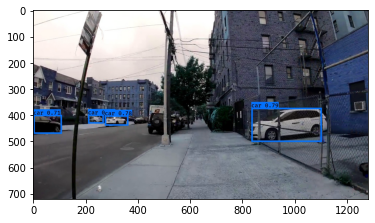

In [49]:
#input the file
import os
input_dir = 'input_videos'


input_file_name = '1.mp4'

input_file(os.path.join(input_dir,input_file_name))

if not os.path.isfile('message.txt'):
  raise Exception('message file has not created')

file = open('message.txt','r')
instructions = file.readline()      #list of instructions saved in message.txt

print(instructions)


# **The End**

Found 4 boxes for 5_frame_00003.jpg
umbrella 0.61 (822, 302) (1045, 350)
car 0.69 (18, 376) (160, 428)
car 0.84 (441, 380) (571, 460)
car 0.91 (8, 377) (429, 617)


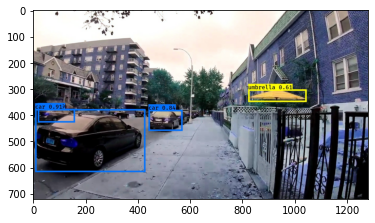

In [ ]:

image_file = '5_frame_00003.jpg'
if not os.path.isfile(os.path.join(input_dir,image_file)):
  raise Exception('image not found')


out_scores, out_boxes, out_classes = predict(sess, image_file)

text = extract_suitable_object_info(out_scores,out_boxes,out_classes,objects)
# objects_name= ""
# # if(len(out_boxes)==0 or max(out_boxes[:,2])<360):
# #   objects_name = ""
# if(len(out_boxes)==0 or max(out_boxes[:,2])<450) or max(out_boxes[:,3])<300 or max(out_boxes[:,1])>1000:
#   objects_name = ""
# else:
#   i,j = np.where(out_boxes==max(out_boxes[:,2]))
#   print(i)
#   print(j)
#   objects_name = objects[out_classes[i[0]]][:-1]

from gtts import gTTS
# text = ""
if len(text)==0:
  text = 'Route clear'
# else:
#   text = "Stay Alert, there is a "+objects_name+ "ahead"
language='en'
myob=gTTS(text=text,lang=language,slow=False)
myob.save(os.getcwd()+'/person1.mp3')
import IPython.display as ipd
ipd.Audio(filename='person1.mp3',autoplay = True)  

In [ ]:
#os.listdir(input_dir)
out_boxes

array([[381.08466 ,   6.144905, 720.3249  , 382.68115 ],
       [398.37283 , 796.7623  , 500.50818 , 905.0747  ],
       [395.6433  , 296.71927 , 424.38086 , 363.94547 ]], dtype=float32)

In [ ]:
out_classes

array([2, 2, 0, 2])

In [ ]:
2_frame_00001.jpg
image_file = '2_frame_00002.jpg'

which one first
nd how big is it...like car in small size....is ignoreable

In [ ]:
l = [1,2,3]
for i,j in enumerate(l):
  print(str(i)+' '+str(j))

0 1
1 2
2 3
